## Full example. Titanic dataset

###Your first goal always should be getting a generalized prediction as fast as possible.
* This doesn't mean to skip exploratory data analysis (EDA). It just means to not get caught up on it. Initially do only what is needed to get a generalized prediction.
* Getting a prediction first lets you set a benchmark for yourself. As you make improvements to the model, you should be able to see your desired error metric improve.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
import math
# With the goal above, I will import just what I need. 
# The model to use (I already imported it above, but will do it again here so each example is self-contained)
from sklearn.ensemble import RandomForestRegressor

%pylab inline

/Applications/Python/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Applications/Python/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Import the data
X = pd.read_csv("train.csv")

In [3]:
X.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


I know that there are categorical variables in the dataset, but I will skip them for the moment. I will impute age though, because it will be fast.

In [4]:
# Impute Age with mean
X["Age"].fillna(X.Age.mean(), inplace=True)

# Confirm the code is correct
X.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# Get just the numeric variables by selecting only the variables that are not "object" datatypes.
numeric_variables = list(X.dtypes[X.dtypes != "object"].index)
X[numeric_variables].head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


I notice PassengerId looks like a worthless variable. I leave it in for two reasons. First, I don't want to go through the effort of dropping it (although that would be very easy). Second, I am interested in seeing if it is useful for prediction. It might be useful if the PassengerId was assigned in some non-random way. For example, perhaps PassengerId was assigned based on when the ticket was purchased in which case there might be something predictive about people who purchased their tickets early or late.

In [6]:
# Let's build our first model. I always have oob_score=True. It is a good idea to increase n_estimators to a number higher than 
# the default. In this case the oob_predictions will be based on a forest of 33 trees. I set random_state=42 so that you all can
# replicate the model exactly.
#model = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42)

# I only use numeric_variables because I have yet to dummy out the categorical variables
#model.fit(X[numeric_variables], y)

In [7]:
# For regression, the oob_score_ attribute gives the R^2 based on the oob predictions. We want to use c-stat, but I mention this 
# for awareness. By the way, attributes in sklearn that have a trailing underscore are only available after the model has been fit.
#model.oob_score_

In [8]:
#y_oob = model.oob_prediction_
#print "c-stat: ", roc_auc_score(y, y_oob)

We now have a benchmark. This isn't very good for this dataset; however, it provides us a benchmark for improvement. Before changing parameters for the Random Forest, let's whip this dataset into shape.

In [9]:
# Here is a simple function to show descriptive stats on the categorical variables
def describe_categorical(X):
    """
    Just like .describe(), but returns the results for
    categorical variables only.
    """
    from IPython.display import display, HTML
    display(HTML(X[X.columns[X.dtypes == "object"]].describe().to_html()))

In [10]:
describe_categorical(X)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Graham, Mr. George Edward",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


In [11]:
X.Cabin.value_counts()


C23 C25 C27        4
G6                 4
B96 B98            4
D                  3
C22 C26            3
E101               3
F2                 3
F33                3
B57 B59 B63 B66    2
C68                2
B58 B60            2
E121               2
D20                2
E8                 2
E44                2
B77                2
C65                2
D26                2
E24                2
E25                2
B20                2
C93                2
D33                2
E67                2
D35                2
D36                2
C52                2
F4                 2
C125               2
C124               2
                  ..
F G63              1
A6                 1
D45                1
D6                 1
D56                1
C101               1
C54                1
D28                1
D37                1
B102               1
D30                1
E17                1
E58                1
F E69              1
D10 D12            1
E50                1
A14          

In [12]:
X.Embarked.value_counts()


S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [13]:
# Change the Cabin variable to be only the first letter or None
def clean_embarked(x):
    try:
        return x[0]
    except TypeError:
        return "None"

X["Embarked"] = X.Embarked.apply(clean_embarked)

In [14]:

def setEmbarked(m):
    if m == "None":
        return "S"
    else:
        return m
X['Embarked'] = X['Embarked'].map(setEmbarked)

In [15]:
X.Embarked.value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [16]:
# Change the Cabin variable to be only the first letter or None
def embarked(x):
    if x=="None":
        return "S"
    else:
        return x

X['Embarked'] = X['Embarked'].map(clean_embarked)

In [17]:
X.Embarked.value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [18]:
X.Cabin.value_counts()

C23 C25 C27        4
G6                 4
B96 B98            4
D                  3
C22 C26            3
E101               3
F2                 3
F33                3
B57 B59 B63 B66    2
C68                2
B58 B60            2
E121               2
D20                2
E8                 2
E44                2
B77                2
C65                2
D26                2
E24                2
E25                2
B20                2
C93                2
D33                2
E67                2
D35                2
D36                2
C52                2
F4                 2
C125               2
C124               2
                  ..
F G63              1
A6                 1
D45                1
D6                 1
D56                1
C101               1
C54                1
D28                1
D37                1
B102               1
D30                1
E17                1
E58                1
F E69              1
D10 D12            1
E50                1
A14          

In [19]:
# Drop the variables I don't feel like dealing with for this tutorial
X.drop(["Name", "Ticket", "PassengerId"], axis=1, inplace=True)

In [20]:
categorical_variables = ['Sex', 'Cabin', 'Embarked']

for variable in categorical_variables:
    # Fill missing data with the word "Missing"
    X[variable].fillna("Missing", inplace=True)
    # Create array of dummies
    dummies = pd.get_dummies(X[variable], prefix=variable)
    # Update X to include dummies and drop the main variable
    X = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1, inplace=True)

In [21]:
X

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A10,Cabin_A14,...,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_Missing,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.000000,1,0,7.2500,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
1,1,1,38.000000,1,0,71.2833,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,3,26.000000,0,0,7.9250,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,1,1,35.000000,1,0,53.1000,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,3,35.000000,0,0,8.0500,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
5,0,3,29.699118,0,0,8.4583,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
6,0,1,54.000000,0,0,51.8625,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
7,0,3,2.000000,3,1,21.0750,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
8,1,3,27.000000,0,2,11.1333,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
9,1,2,14.000000,1,0,30.0708,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [22]:
# Look at all the columns in the dataset
def printall(X, max_rows=10):
    from IPython.display import display, HTML
    display(HTML(X.to_html(max_rows=max_rows)))
    
printall(X)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A10,Cabin_A14,Cabin_A16,Cabin_A19,Cabin_A20,Cabin_A23,Cabin_A24,Cabin_A26,Cabin_A31,Cabin_A32,Cabin_A34,Cabin_A36,Cabin_A5,Cabin_A6,Cabin_A7,Cabin_B101,Cabin_B102,Cabin_B18,Cabin_B19,Cabin_B20,Cabin_B22,Cabin_B28,Cabin_B3,Cabin_B30,Cabin_B35,Cabin_B37,Cabin_B38,Cabin_B39,Cabin_B4,Cabin_B41,Cabin_B42,Cabin_B49,Cabin_B5,Cabin_B50,Cabin_B51 B53 B55,Cabin_B57 B59 B63 B66,Cabin_B58 B60,Cabin_B69,Cabin_B71,Cabin_B73,Cabin_B77,Cabin_B78,Cabin_B79,Cabin_B80,Cabin_B82 B84,Cabin_B86,Cabin_B94,Cabin_B96 B98,Cabin_C101,Cabin_C103,Cabin_C104,Cabin_C106,Cabin_C110,Cabin_C111,Cabin_C118,Cabin_C123,Cabin_C124,Cabin_C125,Cabin_C126,Cabin_C128,Cabin_C148,Cabin_C2,Cabin_C22 C26,Cabin_C23 C25 C27,Cabin_C30,Cabin_C32,Cabin_C45,Cabin_C46,Cabin_C47,Cabin_C49,Cabin_C50,Cabin_C52,Cabin_C54,Cabin_C62 C64,Cabin_C65,Cabin_C68,Cabin_C7,Cabin_C70,Cabin_C78,Cabin_C82,Cabin_C83,Cabin_C85,Cabin_C86,Cabin_C87,Cabin_C90,Cabin_C91,Cabin_C92,Cabin_C93,Cabin_C95,Cabin_C99,Cabin_D,Cabin_D10 D12,Cabin_D11,Cabin_D15,Cabin_D17,Cabin_D19,Cabin_D20,Cabin_D21,Cabin_D26,Cabin_D28,Cabin_D30,Cabin_D33,Cabin_D35,Cabin_D36,Cabin_D37,Cabin_D45,Cabin_D46,Cabin_D47,Cabin_D48,Cabin_D49,Cabin_D50,Cabin_D56,Cabin_D6,Cabin_D7,Cabin_D9,Cabin_E10,Cabin_E101,Cabin_E12,Cabin_E121,Cabin_E17,Cabin_E24,Cabin_E25,Cabin_E31,Cabin_E33,Cabin_E34,Cabin_E36,Cabin_E38,Cabin_E40,Cabin_E44,Cabin_E46,Cabin_E49,Cabin_E50,Cabin_E58,Cabin_E63,Cabin_E67,Cabin_E68,Cabin_E77,Cabin_E8,Cabin_F E69,Cabin_F G63,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_Missing,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.000000,1,0,7.2500,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,1,1,38.000000,1,0,71.2833,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,3,26.000000,0,0,7.9250,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,1,1,35.000000,1,0,53.1000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,3,35.000000,0,0,8.0500,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.000000,0,0,13.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [23]:
X.drop(["Sex_male"], axis=1, inplace=True)

In [24]:
X

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Cabin_A10,Cabin_A14,Cabin_A16,...,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_Missing,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.000000,1,0,7.2500,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,1,1,38.000000,1,0,71.2833,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,3,26.000000,0,0,7.9250,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,1,1,35.000000,1,0,53.1000,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,3,35.000000,0,0,8.0500,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
5,0,3,29.699118,0,0,8.4583,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
6,0,1,54.000000,0,0,51.8625,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,0,3,2.000000,3,1,21.0750,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
8,1,3,27.000000,0,2,11.1333,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
9,1,2,14.000000,1,0,30.0708,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [25]:
y = X.pop("Survived")

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [27]:
model = RandomForestRegressor(100, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X, y)
print "C-stat: ", roc_auc_score(y, model.oob_prediction_)

C-stat:  0.863278795045


This is a pretty good model. Now, before we try some different parameters for the model, let's use the Random Forest to help us with some EDA.

### Variable importance measures

In [28]:
model.feature_importances_

array([  9.13147761e-02,   2.10973305e-01,   4.08007573e-02,
         1.99434144e-02,   1.92211197e-01,   3.02245876e-01,
         1.05875479e-03,   3.41297578e-04,   0.00000000e+00,
         5.50279399e-04,   1.51662236e-03,   2.08100970e-03,
         2.91653184e-04,   2.55236865e-03,   9.52921519e-04,
         3.01600962e-04,   4.07811191e-05,   0.00000000e+00,
         6.15782233e-05,   1.06770401e-03,   1.96004393e-04,
         5.21848928e-04,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.90359621e-03,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   2.88439701e-04,   9.11166104e-04,
         0.00000000e+00,   0.00000000e+00,   2.13533502e-03,
         0.00000000e+00,   7.86517007e-04,   0.00000000e+00,
         5.63604453e-04,   7.40137018e-04,   0.00000000e+00,
         2.20305948e-04,   0.00000000e+00,   4.21625133e-04,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

/Applications/Python/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  app.launch_new_instance()


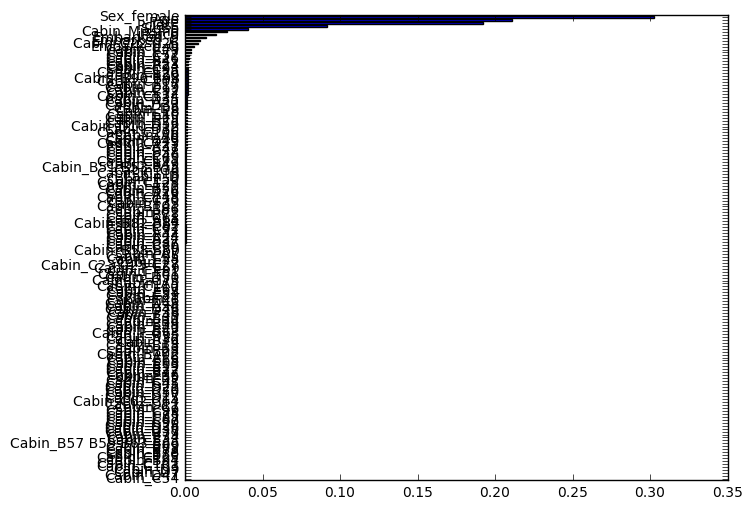

In [29]:
# Simple version that shows all of the variables
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort()
feature_importances.plot(kind="barh", figsize=(7,6));

/Applications/Python/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:41: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


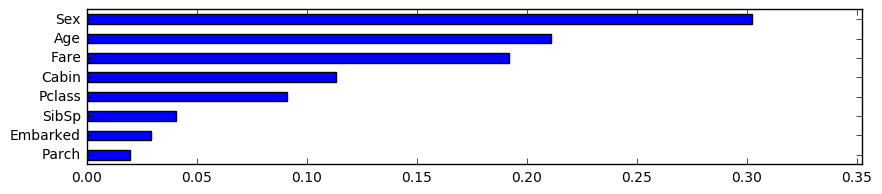

In [30]:
# Complex version that shows the summary view

def graph_feature_importances(model, feature_names, autoscale=True, headroom=0.05, width=10, summarized_columns=None):
    """
    By Mike Bernico
    
    Graphs the feature importances of a random decision forest using a horizontal bar chart. 
    Probably works but untested on other sklearn.ensembles.
    
    Parameters
    ----------
    ensemble = Name of the ensemble whose features you would like graphed.
    feature_names = A list of the names of those featurs, displayed on the Y axis.
    autoscale = True (Automatically adjust the X axis size to the largest feature +.headroom) / False = scale from 0 to 1
    headroom = used with autoscale, .05 default
    width=figure width in inches
    summarized_columns = a list of column prefixes to summarize on, for dummy variables (e.g. ["day_"] would summarize all day_ vars
    """
    
    if autoscale:
        x_scale = model.feature_importances_.max()+ headroom
    else:
        x_scale = 1
    
    feature_dict=dict(zip(feature_names, model.feature_importances_))
    
    if summarized_columns: 
        #some dummy columns need to be summarized
        for col_name in summarized_columns: 
            #sum all the features that contain col_name, store in temp sum_value
            sum_value = sum(x for i, x in feature_dict.iteritems() if col_name in i )  
            
            #now remove all keys that are part of col_name
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i ]
            for i in keys_to_remove:
                feature_dict.pop(i)
            #lastly, read the summarized field
            feature_dict[col_name] = sum_value
        
    results = pd.Series(feature_dict.values(), index=feature_dict.keys())
    results.sort(axis=1)
    results.plot(kind="barh", figsize=(width,len(results)/4), xlim=(0,x_scale))
    
graph_feature_importances(model, X.columns, summarized_columns=categorical_variables)

## Parameter tests

Parameters to test

 * ###Parameters that will make your model better
  * <b>n_estimators</b>: The number of trees in the forest. Choose as high of a number as your computer can handle.
  * <b>max_features</b>: The number of features to consider when looking for the best split. Try ["auto", "None", "sqrt", "log2", 0.9, and 0.2]
  * <b>min_samples_leaf</b>: The minimum number of samples in newly created leaves.Try [1, 2, 3]. If 3 is the best, try higher numbers such as 1 through 10.
 * ###Parameters that will make it easier to train your model
  * <b>n_jobs</b>: Determines if multiple processors should be used to train and test the model. Always set this to -1 and %%timeit vs. if it is set to 1. It should be much faster (especially when many trees are trained).

### n_jobs

In [31]:
%%timeit
model = RandomForestRegressor(1000, oob_score=True, n_jobs=1, random_state=42)
model.fit(X, y)

1 loop, best of 3: 8.63 s per loop


In [32]:
%%timeit
model = RandomForestRegressor(1000, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X, y)

1 loop, best of 3: 6.05 s per loop


### n_estimators

30 trees
C-stat:  0.856394933904

50 trees
C-stat:  0.860951330969

100 trees
C-stat:  0.863278795045

200 trees
C-stat:  0.862024520926

500 trees
C-stat:  0.86471947933

1000 trees
C-stat:  0.865198819757

2000 trees
C-stat:  0.865574303092



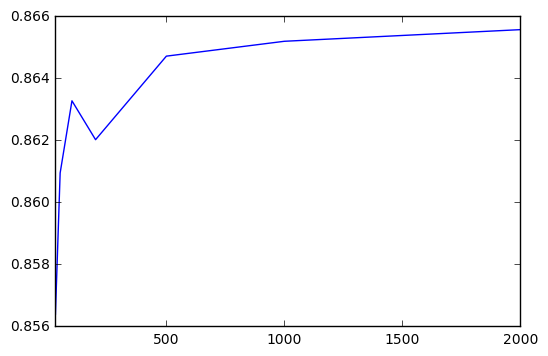

In [33]:
results = []
n_estimator_options = [30, 50, 100, 200, 500, 1000, 2000]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees, oob_score=True, n_jobs=-1, random_state=42)
    model.fit(X, y)
    print trees, "trees"
    roc = roc_auc_score(y, model.oob_prediction_)
    print "C-stat: ", roc
    results.append(roc)
    print ""
    
pd.Series(results, n_estimator_options).plot();

### max_features

auto option
C-stat:  0.865198819757

None option
C-stat:  0.865198819757

sqrt option
C-stat:  0.868330510551

log2 option
C-stat:  0.868383770598

0.9 option
C-stat:  0.866919119292

0.2 option
C-stat:  0.868423715634



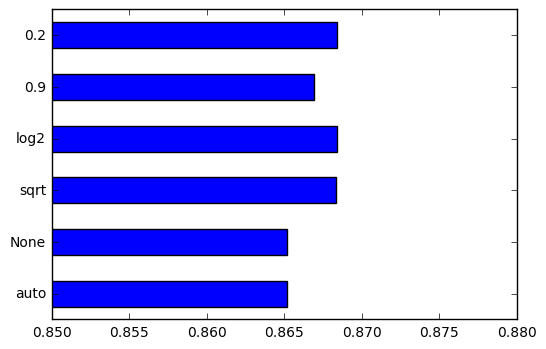

In [34]:
results = []
max_features_options = ["auto", None, "sqrt", "log2", 0.9, 0.2]

for max_features in max_features_options:
    model = RandomForestRegressor(n_estimators=1000, oob_score=True, n_jobs=-1, random_state=42, max_features=max_features)
    model.fit(X, y)
    print max_features, "option"
    roc = roc_auc_score(y, model.oob_prediction_)
    print "C-stat: ", roc
    results.append(roc)
    print ""
    
pd.Series(results, max_features_options).plot(kind="barh", xlim=(.85,.88));

### min_samples_leaf

1 min samples
C-stat:  0.865198819757

2 min samples
C-stat:  0.869206638332

3 min samples
C-stat:  0.870889655834

4 min samples
C-stat:  0.873816295444

5 min samples
C-stat:  0.874561936109

6 min samples
C-stat:  0.87465247819

7 min samples
C-stat:  0.87336358504

8 min samples
C-stat:  0.87165926352

9 min samples
C-stat:  0.86919332332

10 min samples
C-stat:  0.86728661362



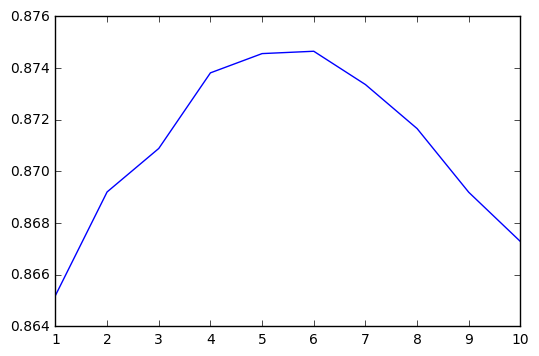

In [35]:
results = []
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for min_samples in min_samples_leaf_options:
    model = RandomForestRegressor(n_estimators=1000, 
                                  oob_score=True, 
                                  n_jobs=-1, 
                                  random_state=42, 
                                  max_features="auto", 
                                  min_samples_leaf=min_samples)
    model.fit(X, y)
    print min_samples, "min samples"
    roc = roc_auc_score(y, model.oob_prediction_)
    print "C-stat: ", roc
    results.append(roc)
    print ""
    
pd.Series(results, min_samples_leaf_options).plot();

## Final model

In [36]:
model = RandomForestRegressor(n_estimators=1000, 
                              oob_score=True, 
                              n_jobs=-1, 
                              random_state=42, 
                              max_features="auto", 
                              min_samples_leaf=5)
model.fit(X, y)
roc = roc_auc_score(y, model.oob_prediction_)
print "C-stat: ", roc

C-stat:  0.874561936109


In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

In [38]:
### Grid Search
n_estimators = [300,400,500]
max_features = ['auto', 'sqrt','log2']
min_samples_split = [3,5,7]


rfc = RandomForestClassifier(n_jobs=1)
#Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(rfc,
                         dict(n_estimators=n_estimators,
                              max_features=max_features,
                              min_samples_split=min_samples_split
                              ), cv=None, n_jobs=-1)

In [39]:
estimator.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [3, 5, 7], 'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [300, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [41]:
estimator.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=7, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [42]:
best_rfc = estimator.best_estimator_

In [43]:
accuracy = accuracy_score(y_test, best_rfc.predict(X_test))
print "Accuracy: ", accuracy

Accuracy:  0.832402234637


In [44]:
y_hat = best_rfc.predict(X_test)

In [45]:
y_hat

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1])

In [46]:
y_test

709    1
439    0
840    0
720    1
39     1
290    1
300    1
333    0
208    1
136    1
137    0
696    0
485    0
244    0
344    0
853    1
621    1
653    1
886    0
110    0
294    0
447    1
192    1
682    0
538    0
819    0
30     0
673    1
63     0
396    0
      ..
668    0
584    0
514    0
688    0
109    1
77     0
611    0
643    1
82     1
518    1
657    0
296    0
507    1
808    0
375    1
5      0
54     0
398    0
457    1
521    0
363    0
97     1
417    1
572    1
852    0
433    0
773    0
25     1
84     1
10     1
Name: Survived, dtype: int64

In [47]:
correct = 0
total = y_test.shape[0]
for pred_val, truth_val in zip(y_hat, y_test):
    if pred_val == truth_val:
        correct +=1

print correct / float(total)

0.832402234637


In [48]:
print classification_report(y_test, best_rfc.predict(X_test))

             precision    recall  f1-score   support

          0       0.83      0.90      0.86       105
          1       0.84      0.73      0.78        74

avg / total       0.83      0.83      0.83       179



In [49]:
print confusion_matrix(y_test, best_rfc.predict(X_test))

[[95 10]
 [20 54]]


In [50]:
roc = roc_auc_score(y_test, best_rfc.predict_proba(X_test)[:,1])
print "AUC Score: ", roc

AUC Score:  0.887001287001
